# 0. Preparation

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling"

In [2]:
MY_HOME_ABS_PATH

'/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling'

## Import libraries

In [4]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib_for_nbinstance import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-09 00:29:21.985477: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 00:29:22.036707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 00:29:22.708790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


In [6]:
from temporal_fusion_transformer_swish import TemporalFusionTransformer as TemporalFusionTransformer_Swish



# Load data from Azure blob

In [7]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Define Constants, Functions

In [8]:
model_dir = "16_tft_nogpp_custom_Swish_7D_small_lr_230408_1928"
exp_model_dir = f"/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/version_0/checkpoints/"
checkpt = 'epoch=14-step=157065.ckpt' #os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=14-step=157065.ckpt


In [10]:
best_tft = TemporalFusionTransformer_Swish.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 #*5
ENCODER_LEN = 24*7#3   # 7 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 8760.


In [11]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [12]:
def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

In [13]:
def get_preds_actuals_agg(dataloader):
    # Get preds for site
    preds = best_tft.predict(dataloader, mode="prediction", return_x=False)
    
    # Get actuals and mask from dataloader
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    actuals = actuals.reshape(-1)
    preds = preds.reshape(-1)
    
    return preds, actuals, mask

## Prepare Dataloaders

In [14]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)
train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df, ENCODER_LEN)

Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760
Subset num test timesteps: 219000


## Select split to evalaute

In [15]:
# eval_split = 'val'

# if eval_split == 'val':
#     dataloader = validation
#     split_df = val_df.copy()
# elif eval_split == 'test':
#     dataloader = test
#     split_df = test_df.copy()

## Eval split

In [16]:
preds_agg_val, actuals_agg_val, mask_agg_val = get_preds_actuals_agg(validation)
rmse_agg_val, mae_agg_val, nse_agg_val = get_eval_metrics_simple(actuals_agg_val, preds_agg_val, mask_agg_val)
print(f" Average metrics for val: RMSE={rmse_agg_val}, MAE={mae_agg_val}, NSE={nse_agg_val}")

 Average metrics for val: RMSE=3.8480095863342285, MAE=2.16750168800354, NSE=0.7187488079071045


## Get Interpretation Plots

In [17]:
raw_preds =  best_tft.predict(validation, mode="raw", return_x=False)

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

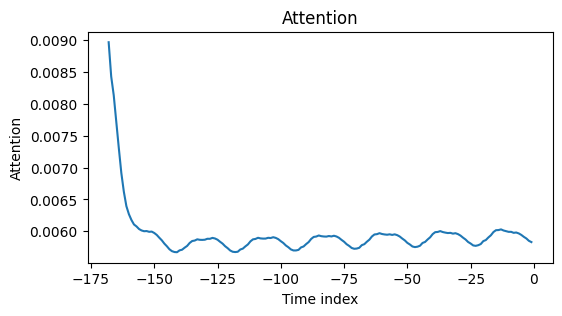

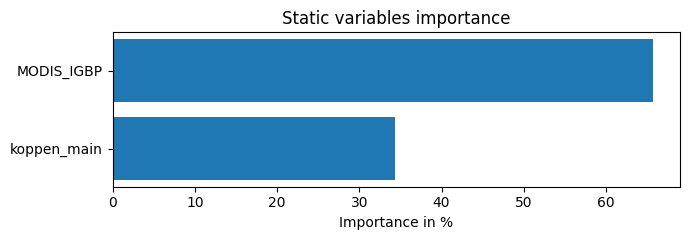

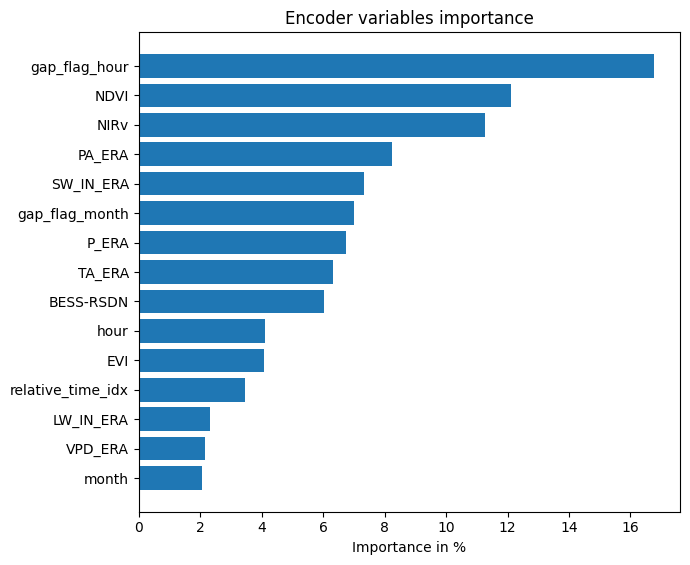

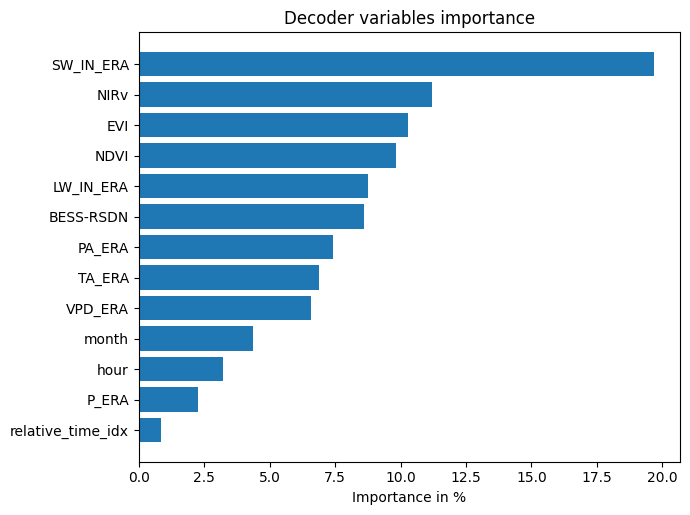

In [18]:
interpretation_sum = best_tft.interpret_output(raw_preds, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)